In [311]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
import numpy as np

# Objective: Compare 3 different strategies to pick stocks to invest in on a given day.  Assume a 20 day holding period.

**&emsp;
 Evaluate the momentum for each industry sector and compute the relative strength vs the s&p 500 for a 20 day back period.  Choose the top 3 industries that are most outperforming the market.  Then find the top 3 stocks that have the best relative strength with respect to the selected industry sector**
**Three strategies**
* **Slope:** *Use the slope (from a linear regression) of the relative strength values to determine the best industries/stocks*
* **Corr:** *Use the pearson correlation coefficient between the relative strength values and the passing of time to determine the best industries/stocks.*
* **Product:** *Use the product of the slope and the correlation coefficient to determine the best industries/stocks*

*The idea is to look for consistently increasing momentum.  The optimal industries/stocks were determined with code in other python files. The results were stored in csv files which are used in this notebook**

In [437]:
nyse = mcal.get_calendar('NYSE')
def get_end_date(start, periods=20):
    end_date = pd.Timestamp(start) + pd.Timedelta(days=periods * 2)
    trading_days = nyse.valid_days(start_date=start, end_date=end_date)

    if len(trading_days) < periods:
        print(f"Not enough trading days from {start}")
        return None
    print(start)
    print(trading_days[periods-1].strftime('%Y-%m-%d'))
    return trading_days[periods-1].strftime('%Y-%m-%d')

def get_one_day(ticker, date):
    data = yf.download(ticker, start=date, end=pd.to_datetime(date) + pd.Timedelta(days=1))
    try:
        day = data['Adj Close'].values[0]
    except IndexError:
        try:
            data= yf.download(ticker, start=date, end=pd.to_datetime(date) + pd.Timedelta(days=2))
            day = data['Adj Close'].values[0]
        except:
            day = np.nan
            print(f"No data for {ticker} on {date}")
    return day

def get_difference(ticker, start, periods=20):
    end_date = get_end_date(start, periods=periods)
    
    if end_date is None:
        return pd.Series([np.nan, np.nan, np.nan])
    
    before = get_one_day(ticker, start)
    after = get_one_day(ticker, end_date)
    
    if np.isnan(before) or np.isnan(after):
        return pd.Series([before, after, np.nan])
    
    return pd.Series([before, after, (after-before)/before])

RERUN = False
period=20
if RERUN:
    df20_all=pd.read_csv(f'best_stocks_20_trading_day_period_alldays.csv')
    df20_all[['Start_Close', '20_days Close', 'Percent Gain']] = df20_all.apply(
    lambda x: get_difference(x['Stock'], x['End Date'],periods=period), axis=1)
    df20_all.to_csv(f'Best_stocks_next_{period}_days_all_days.csv', index=False)
    
    df20=pd.read_csv(f'best_stocks_20_trading_day.csv')
    df20[['Start_Close', '20_days Close', 'Percent Gain']] = df20.apply(
    lambda x: get_difference(x['Stock'], x['End Date'],periods=period), axis=1)
    df20.to_csv(f'Best_stocks_next_{period}_days.csv', index=False)


else:
    print('Read from csv (already has data for the holding period of 20 days ahead of the end_date)')
    df20_all=pd.read_csv(f'Best_stocks_next_{period}_days_all_days.csv')
    df20 = pd.read_csv(f'Best_stocks_next_{period}_days.csv')
    print('You are using 20 day investment periods')
    df20=df20.dropna()
    df20.info()

Read from csv (already has data for the holding period of 20 days ahead of the end_date)
You are using 20 day investment periods
<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 0 to 881
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Start Date     864 non-null    object 
 1   End Date       864 non-null    object 
 2   Metric         864 non-null    object 
 3   Industry       864 non-null    object 
 4   Stock          864 non-null    object 
 5   Stock_Rank     864 non-null    int64  
 6   Industry_Rank  864 non-null    int64  
 7   Start_Close    864 non-null    float64
 8   20_days Close  864 non-null    float64
 9   Percent Gain   864 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 74.2+ KB


# What the data looks like

In [315]:
df20[df20['Metric']=='Slope'].head(5)

Start Date    End Date Metric Industry Stock  Stock_Rank  Industry_Rank  \
0  2022-01-03  2022-02-01  Slope      XLE   EOG           1              1   
1  2022-01-03  2022-02-01  Slope      XLE   COP           2              1   
2  2022-01-03  2022-02-01  Slope      XLE   SLB           3              1   
3  2022-01-03  2022-02-01  Slope      XLP    PM           1              2   
4  2022-01-03  2022-02-01  Slope      XLP    PG           2              2   

   Start_Close  20_days Close  Percent Gain  
0    98.842262     101.663101      0.028539  
1    82.350212      87.664856      0.064537  
2    37.746002      36.091072     -0.043844  
3    90.319290      88.735970     -0.017530  
4   149.996552     143.958740     -0.040253

In [317]:
df20[df20['Metric']=='Corr'].head(5)

Start Date    End Date Metric Industry Stock  Stock_Rank  Industry_Rank  \
297  2022-01-03  2022-02-01   Corr      XLE   EOG           1              1   
298  2022-01-03  2022-02-01   Corr      XLE   SLB           2              1   
299  2022-01-03  2022-02-01   Corr      XLE   XOM           3              1   
300  2022-01-03  2022-02-01   Corr      XLP    PM           1              2   
301  2022-01-03  2022-02-01   Corr      XLP    MO           2              2   

     Start_Close  20_days Close  Percent Gain  
297    98.842278     101.663078      0.028538  
298    37.745995      36.091068     -0.043844  
299    73.296562      72.587143     -0.009679  
300    90.319283      88.735954     -0.017530  
301    41.052578      41.806507      0.018365

In [319]:
df20[df20['Metric']=='Product'].head(5)

Start Date    End Date   Metric Industry Stock  Stock_Rank  \
594  2022-01-03  2022-02-01  Product      XLE   EOG           1   
595  2022-01-03  2022-02-01  Product      XLE   COP           2   
596  2022-01-03  2022-02-01  Product      XLE   SLB           3   
597  2022-01-03  2022-02-01  Product      XLP    PM           1   
598  2022-01-03  2022-02-01  Product      XLP    MO           2   

     Industry_Rank  Start_Close  20_days Close  Percent Gain  
594              1    98.842262     101.663094      0.028539  
595              1    82.350220      87.664848      0.064537  
596              1    37.746002      36.091068     -0.043844  
597              2    90.319290      88.735970     -0.017530  
598              2    41.052574      41.806499      0.018365

# df20 All has more days

In [321]:
df20_all[df20_all['Metric']=='Product'].head(5)

Start Date    End Date   Metric Industry Stock  Stock_Rank  \
11484  2022-01-03 00:00:00  2022-02-01  Product      XLE   EOG           1   
11485  2022-01-03 00:00:00  2022-02-01  Product      XLE   COP           2   
11486  2022-01-03 00:00:00  2022-02-01  Product      XLE   SLB           3   
11487  2022-01-03 00:00:00  2022-02-01  Product      XLP    PM           1   
11488  2022-01-03 00:00:00  2022-02-01  Product      XLP    MO           2   

       Industry_Rank  Stock_Metric_Sign  Start_Close  20_days Close  \
11484              1               True   113.180000     116.410004   
11485              1               True    91.081856      96.959999   
11486              1               True    39.397327      37.669998   
11487              2               True   103.250000     101.440002   
11488              2               True    50.639999      51.570000   

       Percent Gain  
11484      0.028539  
11485      0.064537  
11486     -0.043844  
11487     -0.017530  
11488      0.018365

**Variable Explanation**
* **20_days_Close** *Represents the closing price after the holding period.*
* **Percent Gain** *Represents the percent gain attained at the end of the holding period.*
* **End Date** *Represents the day investment date.*
* **Start Date** *Represents when the back period began. The date that the relative strength values were generated from**
* **Metric** *Represents the strategy that was used to decide the industry and stock.*
* **Industry_Rank** *Represents the industry rank according to the relative strength program*
* **Stock_Rank** *Represents the stock rank within the chosen industry, according to the relative strength program.*

**Ensure date datatype**

In [439]:
df20['End Date']=pd.to_datetime(df20['End Date']).dt.date

# Functions.

In [441]:
def get_breakdown(invest):
    schedule={1: 0.65*invest,
            2: 0.20*invest,
            3: 0.15*invest}
    return schedule
def Invest(df,ignore_action=True):
    metrics=['Slope','Corr','Product']
    stock_percentages={1:0.65, 2: 0.20,3:0.15}
    D={}
    values={metric:[] for metric in metrics}
    dates={metric: [] for metric in metrics}
    for metric in metrics:
        invest=1000
        value=invest
        data=df[df['Metric']==metric].sort_values(by='End Date')
        schedule=get_breakdown(value)
        for ind, row in data.iterrows():
            if not ignore_action:
                if row['Action']:
                    value+=schedule[row['Industry_Rank']]*stock_percentages[row['Stock_Rank']]*row['Percent Gain']
                    schedule=get_breakdown(value)
            else:
                value+=schedule[row['Industry_Rank']]*stock_percentages[row['Stock_Rank']]*row['Percent Gain']
                schedule=get_breakdown(value)
            if value<0:
                add_amount=abs(value)+1000
                value+=add_amount
                invest+=add_amount
            values[metric].append(value)
            dates[metric].append(pd.to_datetime(row['End Date']))
        D[metric]=[invest,value]
    print('Summary')
    print()
    print('{:<25}{:<25}{:<25}'.format('Strategy','Amount Invested', 'Value after 2.5 years'))
    for key, value in D.items():
        print('{:<25}{:<25}{:<25}'.format(key,value[0], value[1]))
    return D, values, dates


In [443]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_vs_market(df,values,dates,strategy='Corr',holding_period=10):
    start_date = '2022-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    # Fetch VOO data
    voo = yf.Ticker("VOO")
    df_voo= voo.history(start=start_date, end=end_date).reset_index()
    df_voo['Date']=pd.to_datetime(df_voo['Date']).dt.date
    df['End Date']=pd.to_datetime(df['End Date']).dt.date
    df_voo_reduced=df_voo[df_voo['Date'].isin(df['End Date'].unique())]
    df_voo_reduced=df_voo_reduced.sort_values(by='Date')
    df_voo_reduced['Pct_Change'] = (df_voo_reduced['Close'] - df_voo_reduced['Close'].shift(1)) / df_voo['Close'].shift(1) 
    
    print("\nAlternative percentage change calculation:")
    df_voo_reduced[['Date', 'Close', 'Pct_Change']].head()
    invest=1000
    value=invest
    dates_voo=[]
    values_voo=[]
    for ind,row in df_voo_reduced.iterrows():
        if pd.isna(row['Pct_Change']):
            dates_voo.append(row['Date'])
            values_voo.append(invest)
        else:
            value=value+value*row['Pct_Change']
            dates_voo.append(row['Date'])
            values_voo.append(value)
    
    fig, ax=plt.subplots()
    ax.scatter(x=dates[strategy],y=values[strategy], color='blue',label='Portfolio')
    ax.scatter(x=dates_voo,y=values_voo,color='red',label='Market')
    ax.tick_params(axis='x', rotation=45)
    fig.suptitle(f'Portfolio vs. Market\n Holding Period:{holding_period} days\n{strategy}')
    plt.legend()
    plt.show()


In [445]:
import pandas as pd
from scipy import stats

# Assuming your DataFrame is named 'df' and has columns 'End Date', 'Metric', 'Combined Rank', and 'Gain Rank'



def calculate_spearman(group):
    return stats.spearmanr(group['Combined Rank'], group['Gain Rank'])[0]
def combined_rank(industry_rank, stock_rank):
    return (industry_rank - 1) * 3 + stock_rank

def get_correlation(df):
# Rank each stock 1-9 for each metric/period
    df['Combined Rank'] = df.apply(lambda row: combined_rank(row['Industry_Rank'], row['Stock_Rank']), axis=1)
    # First, ensure 'End Date' is in datetime format
    df['End Date'] = pd.to_datetime(df['End Date'])
    
    # Group by 'End Date' and 'Metric', then rank the 'Percent Gain' within each group
    df['Gain Rank'] = df.groupby(['End Date', 'Metric'])['Percent Gain'].rank(method='dense', ascending=False)
    # Group by End Date and Metric, then calculate Spearman correlation
    spearman_correlations = df.groupby(['End Date', 'Metric']).apply(calculate_spearman).reset_index()
    spearman_correlations.columns = ['End Date', 'Metric', 'Spearman Correlation']
    
    # Calculate average Spearman correlation for each Metric
    average_correlations = spearman_correlations.groupby('Metric')['Spearman Correlation'].mean()
    
    print("Average Spearman Correlation Coefficients:")
    print(average_correlations)
    # If you want to see a summary of correlations for each date and metric
    summary = spearman_correlations.pivot(index='End Date', columns='Metric', values='Spearman Correlation')
    print("\nSummary of Spearman Correlations:")
    print(summary.describe())
def count_percent_gain_winners(df):
    winners=[]
    metrics=['Slope','Corr','Product']
    when={metric:[] for metric in metrics}
    for date in df['End Date'].unique():
        data=df[df['End Date']==date]
        grouped=data.groupby('Metric').agg({'Percent Gain':'mean'}).reset_index()
        top=grouped[grouped['Percent Gain']==grouped['Percent Gain'].max()]
        winners+=list(top['Metric'].values)
        when[top['Metric'].values[0]].append(pd.to_datetime(date))
    print(pd.Series(winners).value_counts())
    return when

    








# Average percent gain by strategy

# Investment simulation.  Invest everyday and hold for 20 days.

In [340]:
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar

class Invest:
    def __init__(self,df,period=20,ignore_action=True):
        self.metrics=['Slope','Corr','Product']
        self.df=df
        self.period=period
        self.ignore_action=ignore_action
        self.portfolio_values=[]
        self.dates=[]
        self.totals, self.initial_investments=self.invest(self.df,period=period,ignore_action=ignore_action)
        self.percent_gains=self.get_percentages()
        self.best_metric=self.get_best()
    def get_best(self):
        max=-float('inf')
        for key, value in self.percent_gains.items():
            if value>max:
                max=value
                metric=key
        return metric
    def get_percentages(self):
        percents={}
        for metric in self.metrics:
            percent=100*(self.totals[metric]-self.initial_investments[metric])/self.initial_investments[metric]
            percents[metric]=percent
        return percents
            
    def add_n_trading_days(self, start_date, n):
        
        """
        Returns the date n trading days after the given start date, considering NYSE holidays.
        
        :param start_date: A pandas Timestamp object or a string that can be converted to a date
        :param n: Number of trading days to add
        :return: A pandas Timestamp object representing the date n trading days later
        """
        nyse = CustomBusinessDay(calendar=USFederalHolidayCalendar())
        # Ensure start_date is a pandas Timestamp
        start_date = pd.Timestamp(start_date)
        
        # Add n trading days
        end_date = start_date + n * nyse
        
        return end_date
        
        return result

        
    def invest(self,DF,period=20,ignore_action=True):
        if ignore_action:
            df=DF.copy()
            df['Action']=True
        else:
            df=DF.copy()
        
        
        D={}
        df['End Date']=pd.to_datetime(df['End Date']).dt.date
        df=df.sort_values(by='End Date')
        dates=df['End Date'].unique()
        stock_percentages={1:34/100, 2: 33/100,3:33/100}
        track=[]
        I={}
        for metric in self.metrics:
            dates_when_available=[None for i in range(21)] #For checking
            investments=[1000/21 for i in range(21)] # 21 investment accounts
            
            total_investment=1000
            for i,date in enumerate(dates):
                j=i%21    #Detrmines the investment acount used
                data=df[(df['Metric']==metric)&(df['End Date']==date)] #Gets all the data for a single date (9 rows)
                dates_when_available[j]=self.add_n_trading_days(date,period) #Set the date available for the account to the date 20 days later.
                invest=investments[j] #Take the money in the account
                if invest<=0:
                    invest+=investments[(i+1)%20]/2 #If an account is empty take half the money in the account ahead of it.
                    investments[(i+1)%20]-=invest #Reduce the account ahead of it by the amount taken
                    if invest<=0:
                        back_to_zero=abs(invest)
                        invest=invest+back_to_zero+100
                        total_investment+=back_to_zero+100
                investments[j]=0 #Empty the current account as the money is now in an investment.
                schedule=get_breakdown(invest) #Gets the breakdown in which the stocks will be invested in according to rank
                if invest<=0:
                    print('less than 0')
                investments_for_date=0 #Iterate through the rows for a date
             
                for ind, row in data.iterrows():
                    
                    percent_invest_in_stock=stock_percentages[row['Stock_Rank']]
                    invest_in_industry=schedule[row['Industry_Rank']]
                    amount_invested_date_industry=invest_in_industry*percent_invest_in_stock #Amount put into the investment
                    if row['Stock_Metric_Sign'] and row['Action']: #Only invest if the momentum is positive
                        value_add=amount_invested_date_industry*row['Percent Gain'] #Amount gained from the investment in 20 days
                        investments_for_date+=(amount_invested_date_industry+value_add) #Value of the investment 20 days later
                        
                        
                    else:
                        investments_for_date+=amount_invested_date_industry
                       

                investments[j]=investments_for_date # Add the money invested and gained to the account.  
                    
                self.portfolio_values.append(sum(investments))
                self.dates.append(date)
               
            D[metric]=sum(investments) #Get the sum of all the accounts to a dictionary with corresponding metric key.
            I[metric]=total_investment
            
                
                
        return D,I
        
            
    

# Performance of Simulated Portfolio (2.5 years)

In [342]:
test_df=df20_all.dropna(subset='Percent Gain')
investments=Invest(test_df)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)




Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1206.5461978413662, 'Corr': 1084.2513025665196, 'Product': 1179.1486466905087}

Percent Gains
	 {'Slope': 20.654619784136617, 'Corr': 8.42513025665196, 'Product': 17.91486466905087}


*&emsp;The* **Slope** *strategy outperforms the others*

# Performance by Average Percent gain

In [452]:
metrics=['Slope','Corr', 'Product']
for metric in metrics:
    data=df20_all[df20_all['Metric']==metric]
    print(metric, ": ", data['Percent Gain'].mean())


Slope :  0.00930956061900134
Corr :  0.005715191066200841
Product :  0.008239681371598966


*&emsp;The* **Slope** *strategy has the best average percent gain over the entire period*

# Performance over smaller chunks of time
**&emsp;Look at 80 day periods and compare the performance of the different strategies**

In [347]:
import random
rerun=False

if rerun:
    best_percent_gain=[]
    period=[]
    all_metrics=[]
    portfolio_percents=[]
    percent_changes=[]
    isWinner=[]
    start=[]
    end=[]
    
    all_dates=df20['End Date'].unique()
    ind=0
    for i in range(len(all_dates)//80):
        if i==6:
            ind-=1
        start_date=all_dates[ind]
        end_date= start_date + pd.offsets.BDay(80)
        end_date=end_date.to_pydatetime().date()
    
    
        all_data=df20[(df20['End Date']>=start_date)&(df20['End Date']<=end_date)]
        investments=Invest(all_data)
        for metric in metrics:
            all_metrics.append(metric)
            data=all_data[all_data['Metric']==metric]
            data=data.sort_values(by='End Date')
            percent_changes.append(data['Percent Gain'].mean())
            
            portfolio_percents.append(investments.percent_gains[metric])
            winner=investments.best_metric
            if metric==winner:
                isWinner.append(True)
            else:
                isWinner.append(False)
            start.append(data['End Date'].min())
            end.append(data['End Date'].max())
        print(ind)
        ind+=80
    D={'Period_Start':start, 'Period_End':end, 'Metric':all_metrics, 'Percent_Gain_Portfolio':portfolio_percents, 'Avg_Percent_Gain':percent_changes,
       'isWinner':isWinner}
    results=pd.DataFrame(D)
    results.to_csv('Strategy_Evaluation.csv', index=False)
else:
    results=pd.read_csv('Strategy_Evaluation.csv')




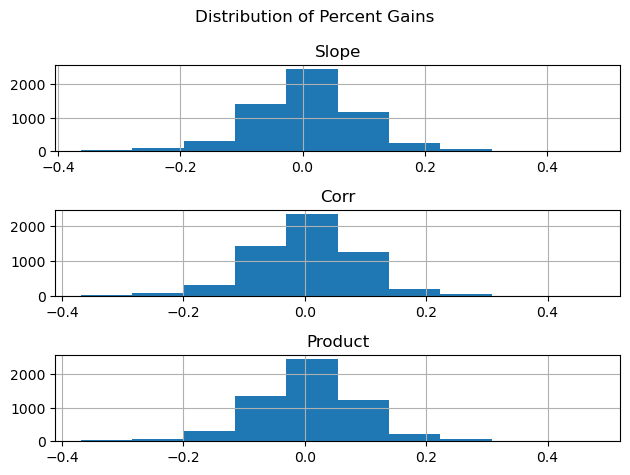

In [455]:
fig, ax=plt.subplots(len(metrics))
for i, metric in enumerate(metrics):    
    df20_all[df20_all['Metric']==metric]['Percent Gain'].hist(ax=ax[i])
    ax[i].set_title(f'{metric}')
fig.suptitle('Distribution of Percent Gains')
plt.tight_layout()
plt.show()

*&emsp;The distributions of the percent gains are very similar.  The most frequent percent gains are around zero.*

# Count the number of times the strategy was the winner for each period.

In [407]:
print("**"*15,'Portfolio Winners','**'*15)
for metric in metrics:
    data=results[results['Metric']==metric]
    print(metric, data['isWinner'].sum())
test_data=results.groupby(['Period_Start','Period_End','Metric']).agg({'Avg_Percent_Gain':'mean'})
data=test_data.reset_index()
print()
print('*'*15,'Average Percent Gain Winners','*'*15)
print()
for start_date in data['Period_Start'].unique():
    lf=data[data['Period_Start']==start_date]
    best=lf.sort_values(by='Avg_Percent_Gain',ascending=False).head(3)
    print(best)
    print()


****************************** Portfolio Winners ******************************
Slope 3
Corr 3
Product 1

*************** Average Percent Gain Winners ***************

  Period_Start  Period_End   Metric  Avg_Percent_Gain
2   2022-02-01  2022-05-24    Slope         -0.001815
1   2022-02-01  2022-05-24  Product         -0.009878
0   2022-02-01  2022-05-24     Corr         -0.024303

  Period_Start  Period_End   Metric  Avg_Percent_Gain
5   2022-05-26  2022-09-15    Slope         -0.030684
4   2022-05-26  2022-09-15  Product         -0.032325
3   2022-05-26  2022-09-15     Corr         -0.037288

  Period_Start  Period_End   Metric  Avg_Percent_Gain
6   2022-09-21  2023-01-11     Corr          0.021414
7   2022-09-21  2023-01-11  Product          0.021248
8   2022-09-21  2023-01-11    Slope          0.018814

   Period_Start  Period_End   Metric  Avg_Percent_Gain
9    2023-01-17  2023-05-09     Corr          0.003668
10   2023-01-17  2023-05-09  Product          0.003487
11   2023-01-17 

**&emsp;For the seven 80 day periods that were tested, slope and corr were the best strategy on 3 occasions, both in terms of portfolio performance and average percent gain.**

# Look for relationships between strategy performance and the behavior of the overall market.
**&emsp;Do some strategies perform better/worse in an increasing/decreasing market?**

In [356]:
def is_decreasing_market(df, period=20, method='moving_average', threshold=0.05):
    """
    Identify decreasing market conditions using various methods.
    
    :param df: DataFrame with 'Date' and 'Close' columns
    :param period: Number of days to consider
    :param method: 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'
    :param threshold: Threshold for considering market as decreasing
    :return: DataFrame with 'isDecreasing' column
    """
    df = df.sort_values(by='End Date').copy()
    
    if method == 'moving_average':
        df['MA'] = df['Close'].rolling(window=period).mean()
        df['isDecreasing'] = df['Close'] < df['MA']
    
    elif method == 'linear_regression':
        def rolling_regression(x):
            return stats.linregress(range(len(x)), x)[0]
        df['Slope'] = df['Close'].rolling(window=period).apply(rolling_regression)
        df['isDecreasing'] = df['Slope'] < 0
    
    elif method == 'percent_change':
        df['PercentChange'] = df['Close'].pct_change(periods=period)
        df['isDecreasing'] = df['PercentChange'] < -threshold
    
    elif method == 'drawdown':
        df['Rolling_Max'] = df['Close'].rolling(window=period, min_periods=1).max()
        df['Drawdown'] = (df['Close'] - df['Rolling_Max']) / df['Rolling_Max']
        df['isDecreasing'] = df['Drawdown'] < -threshold
    
    else:
        raise ValueError("Invalid method. Choose 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'.")
    
    return df


# Get VOO data

In [358]:
import datetime
import pandas as pd
import yfinance as yf

start_date = '2022-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
holding_period = 20

# Fetch VOO data
voo = yf.Ticker("VOO")
df_voo = voo.history(start=start_date, end=end_date).reset_index()

# Convert 'Date' to datetime.date
df_voo['Date'] = pd.to_datetime(df_voo['Date']).dt.date

# Create df_to_join with 'Date' and 'Close'
df_to_join = df_voo[['Date', 'Close']]

# Ensure df20_all['End Date'] is also datetime.date
df20_all['End Date'] = pd.to_datetime(df20_all['End Date']).dt.date

# Now merge
df20_all = pd.merge(df20_all, df_to_join, left_on='End Date', right_on='Date', how='left')



# Get the performance rank for each date (e.g Rank the strategies for each date)

In [371]:
import pandas as pd

# Assuming df20_all is your original dataframe
# and it has columns 'End Date', 'Metric', and 'Percent Gain'

# Step 1: Group by 'End Date' and 'Metric', and calculate mean 'Percent Gain'
grouped = df20_all.groupby(['End Date', 'Metric'])['Percent Gain'].mean().reset_index()

# Step 2: Rank the metrics within each date
ranked = grouped.assign(Performance_Rank=grouped.groupby('End Date')['Percent Gain'].rank(ascending=False, method='dense'))

# Step 3: Sort the dataframe
rank_df = ranked.sort_values(['End Date', 'Performance_Rank']).reset_index(drop=True)

# If you want integer ranks
rank_df['Performance_Rank'] = rank_df['Performance_Rank'].astype(int)


rank_df.head()

End Date   Metric  Percent Gain  Performance_Rank
0  2022-02-01    Slope      0.008620                 1
1  2022-02-01  Product     -0.001444                 2
2  2022-02-01     Corr     -0.003074                 3
3  2022-02-02  Product     -0.001568                 1
4  2022-02-02     Corr     -0.003718                 2

**Merge the VOO data with the ranked data**

In [373]:
import seaborn as sns
rank_df2=pd.merge(rank_df,df_voo, left_on='End Date',right_on='Date')
rank_df2

End Date   Metric  Percent Gain  Performance_Rank        Date  \
0     2022-02-01    Slope      0.008620                 1  2022-02-01   
1     2022-02-01  Product     -0.001444                 2  2022-02-01   
2     2022-02-01     Corr     -0.003074                 3  2022-02-01   
3     2022-02-02  Product     -0.001568                 1  2022-02-02   
4     2022-02-02     Corr     -0.003718                 2  2022-02-02   
...          ...      ...           ...               ...         ...   
1912  2024-08-15  Product      0.036403                 2  2024-08-15   
1913  2024-08-15    Slope      0.033799                 3  2024-08-15   
1914  2024-08-16     Corr      0.053899                 1  2024-08-16   
1915  2024-08-16  Product      0.034208                 2  2024-08-16   
1916  2024-08-16    Slope      0.034208                 2  2024-08-16   

            Open        High         Low       Close   Volume  Dividends  \
0     398.358551  400.954421  395.051232  400.329498  8154900        0.0   
1     398.358551  400.954421  395.051232  400.329498  8154900        0.0   
2     398.358551  400.954421  395.051232  400.329498  8154900        0.0   
3     402.819584  404.934711  400.473695  404.146332  6726500        0.0   
4     402.819584  404.934711  400.473695  404.146332  6726500        0.0   
...          ...         ...         ...         ...      ...        ...   
1912  505.089996  508.589996  504.489990  508.380005  4279000        0.0   
1913  505.089996  508.589996  504.489990  508.380005  4279000        0.0   
1914  506.839996  510.109985  506.649994  509.450012  3449300        0.0   
1915  506.839996  510.109985  506.649994  509.450012  3449300        0.0   
1916  506.839996  510.109985  506.649994  509.450012  3449300        0.0   

      Stock Splits  Capital Gains  
0              0.0            0.0  
1              0.0            0.0  
2              0.0            0.0  
3              0.0            0.0  
4              0.0            0.0  
...            ...            ...  
1912           0.0            0.0  
1913           0.0            0.0  
1914           0.0            0.0  
1915           0.0            0.0  
1916           0.0            0.0  

[1917 rows x 13 columns]

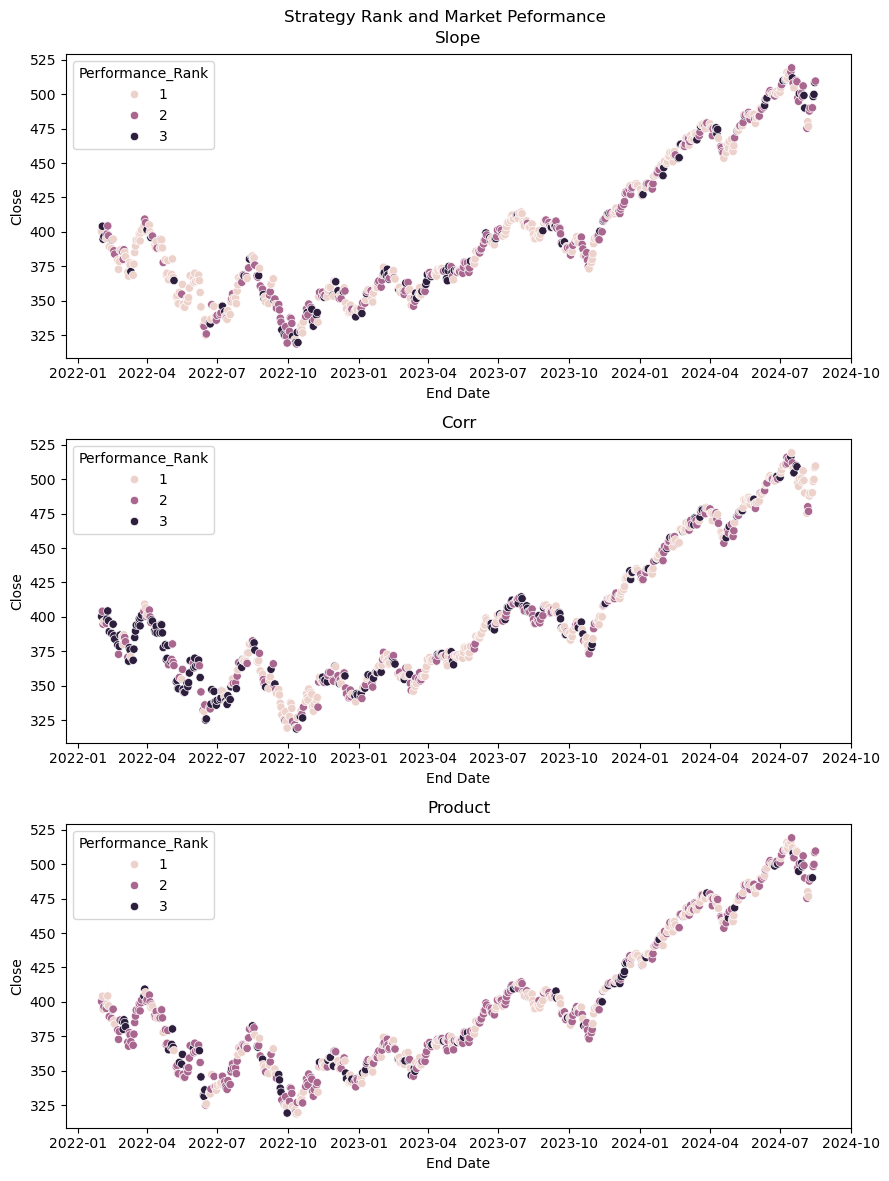

In [414]:
fig, ax=plt.subplots(3, figsize=(9,12))
for i,metric in enumerate(metrics):
    data=rank_df2[rank_df2['Metric']==metric]
    sns.scatterplot(x='End Date',y='Close',hue='Performance_Rank',data=data,ax=ax[i])
    ax[i].set_title(f'{metric}',y=1.01)
fig.suptitle('Strategy Rank and Market Peformance')
plt.tight_layout()
plt.show()
    

**Slope definitely was frequently ranked high in the first half of 2022.  There is no clear correlation between a strategy's rank and the increasing/decreasing behavior of the market from these graphs**

# Average Performance Rank

In [377]:
rank_df2.groupby('Metric').agg({'Performance_Rank':'mean'})

Performance_Rank
Metric                   
Corr             1.863850
Product          1.762128
Slope            1.694836

**Slope** *had the best average rank overall*

# Average Percentage Gain and Average Performance_Rank in increasing/decreasing market

In [387]:
rank_df2=is_decreasing_market(rank_df2)

decreasing_market=rank_df2[rank_df2['isDecreasing']]
increasing_market=rank_df2[~rank_df2['isDecreasing']]
print('Increasing Market\n', increasing_market.groupby('Metric').agg({'Percent Gain':'mean','Performance_Rank':'mean'}))
print()
print('Decreasing Market\n', decreasing_market.groupby('Metric').agg({'Percent Gain':'mean','Performance_Rank':'mean'}))

Increasing Market
          Percent Gain  Performance_Rank
Metric                                 
Corr         0.011852          1.786667
Product      0.013459          1.767810
Slope        0.014356          1.696335

Decreasing Market
          Percent Gain  Performance_Rank
Metric                                 
Corr        -0.003001          1.973485
Product      0.000632          1.753846
Slope        0.001809          1.692607


**Slope performs better in both increasing and decreasing markets. It does so both in terms of overall percentage gain, and in terms of the number of times it is the best strategy on a given date.**